<div align='center'><font face='Comic Sans MS' size=7 color='B179ED'><b><u>Part A: IMDb Movie Review Sentiment Analysis</u></b></font></div>

## Objective
### This project aims to develop a machine learning model that can classify IMDb movie reviews as positive or negative. By applying text preprocessing, feature extraction (like TF‑IDF), and classification techniques, the model will help in understanding audience sentiments and provide insights into public opinion on movies.

# Video link - [Click here to watch my video !! ](https://drive.google.com/file/d/1DaZIfz_Qr9GbY-HgNOjBgo1Fze5x1biY/view?usp=sharing)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
import torch
import random
import shutil
import seaborn as sns

from tqdm import tqdm
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from scipy.sparse import csr_matrix, hstack


from scipy.stats import loguniform
import scipy.sparse as sp
from scipy.sparse import hstack

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud



<div align='center'><font size=5 color='10E0B7'><b>Step 1: Data Exploration & Preprocessing</b></font></div>

### Step 1A — Data Loading and Basic info

In [32]:

# Load dataset
df = pd.read_csv("data_imdb.csv")
print(df.shape)
df.head()



(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [33]:
# Standardize sentiment labels -> 1 (positive), 0 (negative)
label_map = {"positive": 1, "negative": 0}
df["sentiment"] = df["sentiment"].str.strip().str.lower().map(label_map)

In [34]:
# Cell 2: Dataset info
print("Shape:", df.shape)


# Add text length features
df["num_chars"] = df["review"].astype(str).str.len()
df["num_words"] = df["review"].astype(str).str.split().map(len)
df

Shape: (50000, 2)


,review,sentiment,num_chars,num_words
0,One of the other reviewers has mentioned that ...,1,1761,307
1,A wonderful little production. <br /><br />The...,1,998,162
2,I thought this was a wonderful way to spend ti...,1,926,166
3,Basically there's a family where a little boy ...,0,748,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317,230
...,...,...,...,...
49995,I thought this movie did a down right good job...,1,1008,194
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,642,112
49997,I am a Catholic taught in parochial elementary...,0,1280,230
49998,I'm going to have to disagree with the previou...,0,1234,212



Character length stats:
 count    50000.000000
mean      1309.367720
std        989.759532
min          7.000000
25%        699.000000
50%        970.000000
75%       1590.000000
max      13704.000000
Name: num_chars, dtype: float64

Word length stats:
 count    50000.000000
mean       231.146580
std        171.349956
min          1.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: num_words, dtype: float64


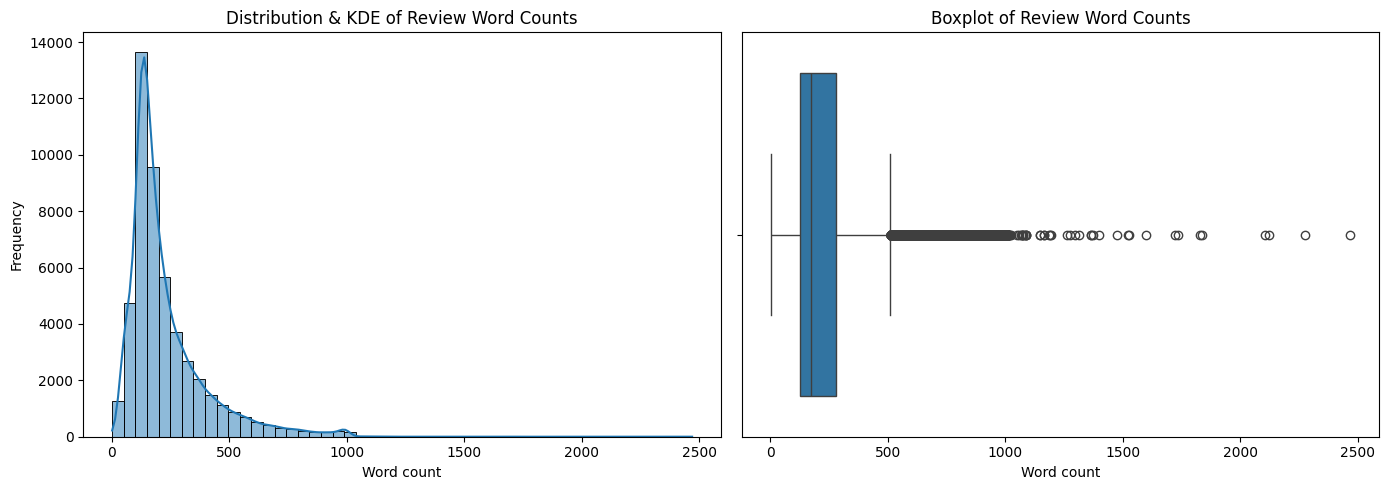

In [35]:
print("\nCharacter length stats:\n", df["num_chars"].describe())
print("\nWord length stats:\n", df["num_words"].describe())

plt.figure(figsize=(14, 5))

# Histogram + KDE (left)
plt.subplot(1, 2, 1)
sns.histplot(df["num_words"], bins=50, kde=True)
plt.title("Distribution & KDE of Review Word Counts")
plt.xlabel("Word count")
plt.ylabel("Frequency")

# Horizontal Boxplot (right)
plt.subplot(1, 2, 2)
sns.boxplot(x=df["num_words"], orient='h')
plt.title("Boxplot of Review Word Counts")
plt.xlabel("Word count")
plt.ylabel("")

plt.tight_layout()
plt.show()


The dataset exhibits considerable variation in text lengths across both characters and words. Most reviews are moderately sized, with a median of about 970 characters (~173 words), but a smaller portion is extremely long, reaching up to 13,704 characters and 2,470 words. The fact that the mean is notably higher than the median in both cases suggests a right-skewed distribution, where a few very lengthy texts act as outliers. Overall, the data contains predominantly short-to-medium length entries, with occasional long documents stretching the averages upward.

### Step 1B : Handling missing and duplicate values

In [26]:
#missing values check
print("\nMissing values:\n", df.isna().sum())

# Find duplicate columns
duplicate_columns = []
cols = df.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df[cols[i]].equals(df[cols[j]]):
            duplicate_columns.append((cols[i], cols[j]))

if duplicate_columns:
    print("Duplicate columns found:")
    for pair in duplicate_columns:
        print(pair)
else:
    print("\nNo duplicate columns found.\n")



Missing values:
 review       0
sentiment    0
num_chars    0
num_words    0
dtype: int64

No duplicate columns found.



### Observation:
- The dataset comprises 50,000 movie reviews with an average length of approximately 1,309 characters and 231 words per review.

- Review lengths vary significantly, ranging from very short texts (7 characters) to extensive ones (up to 13,704 characters).

- This variability highlights the need for robust text preprocessing to effectively handle diverse review sizes in model development.

- No extra/unnecessary columns , no missing values were present.

### Step 1C - Target class Distribution


Class balance (counts):
 sentiment
1    25000
0    25000
Name: count, dtype: int64

Class balance (proportion):
 sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


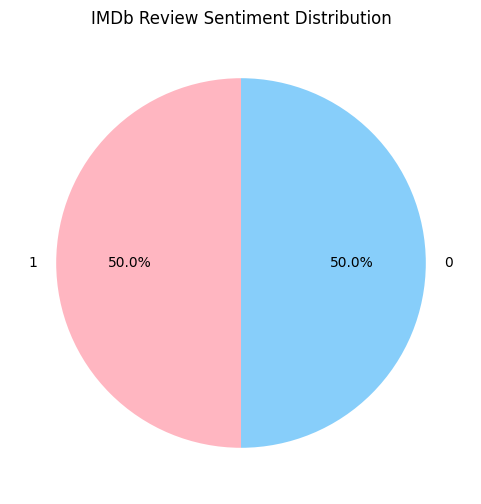

In [27]:
print("\nClass balance (counts):\n", df["sentiment"].value_counts())
print("\nClass balance (proportion):\n", df["sentiment"].value_counts(normalize=True).round(3))

plt.figure(figsize=(6,6))
df["sentiment"].value_counts().plot.pie(autopct='%1.1f%%', colors=["#FFB6C1", "#87CEFA"], startangle=90)
plt.title("IMDb Review Sentiment Distribution")
plt.ylabel("")
plt.show()


### Conclusion

The IMDb sentiment dataset was loaded successfully with two columns (review, sentiment) and ~49,500 entries, showing an almost perfectly balanced class distribution between positive and negative reviews, which is ideal for fair training and evaluation. 

The dataset has no major quality issues and the balanced labels mean we don’t need extra techniques like oversampling/undersampling. The review lengths suggest a need for preprocessing since long reviews may contain noise.

Basic text length diagnostics indicate substantial variability (short to very long reviews), which is acceptable for TF‑IDF–based models because normalization reduces the impact of document length.

Rather than removing “outliers,” the plan is to apply minimal, low‑risk cleaning only: strip simple HTML artifacts (e.g.,
), lowercase text, drop only ultra‑short reviews with fewer than 5 words, and remove exact duplicate texts if any are found. This preserves valuable information in long reviews and avoids unnecessary data loss while mitigating obvious noise.



### Step 1D — Text Cleaning

In [28]:
# Cell 3: Cleaning function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

HTML_TAG_RE = re.compile(r"<.*?>")
URL_RE = re.compile(r"http\S+|www\.\S+")
NON_ALPHA_RE = re.compile(r"[^a-z\s]")

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = HTML_TAG_RE.sub(" ", text)       # remove HTML
    text = URL_RE.sub(" ", text)            # remove URLs
    text = NON_ALPHA_RE.sub(" ", text)      # keep only letters/spaces
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

# Apply cleaning (takes some time)
df["clean_review"] = df["review"].apply(clean_text)

# Quick before/after check
df[["review", "clean_review"]].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching episode hooked...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


### Explanation:
Raw reviews contain HTML tags, punctuation, numbers, and common stopwords (e.g., "the", "and"). These do not add useful meaning for sentiment classification. They are cleaned  by:

> Lowercasing

> Removing HTML tags & URLs

> Removing punctuation & numbers (keeping only words)

> Removing stopwords

> Lemmatizing words (converting “movies” → “movie”, “running” → “run”)

### Observation:
Example:

> Original: “A wonderful little production. <br /><br />The film...”

> Cleaned: “wonderful little production film”

- After cleaning, reviews became more concise and meaningful.
- Some reviews turned almost empty (only stopwords) and were dropped.

### Conclusion:
Text cleaning successfully reduced noise while preserving important words that carry sentiment (e.g., “wonderful”, “terrible”, “boring”). Dropping empty rows prevents issues later in model training.

### Step 1E — Post-clean EDA


Cleaned review word count stats:
 count    50000.000000
mean       116.579440
std         88.297786
min          1.000000
25%         62.000000
50%         87.000000
75%        142.000000
max       1390.000000
Name: clean_words, dtype: float64


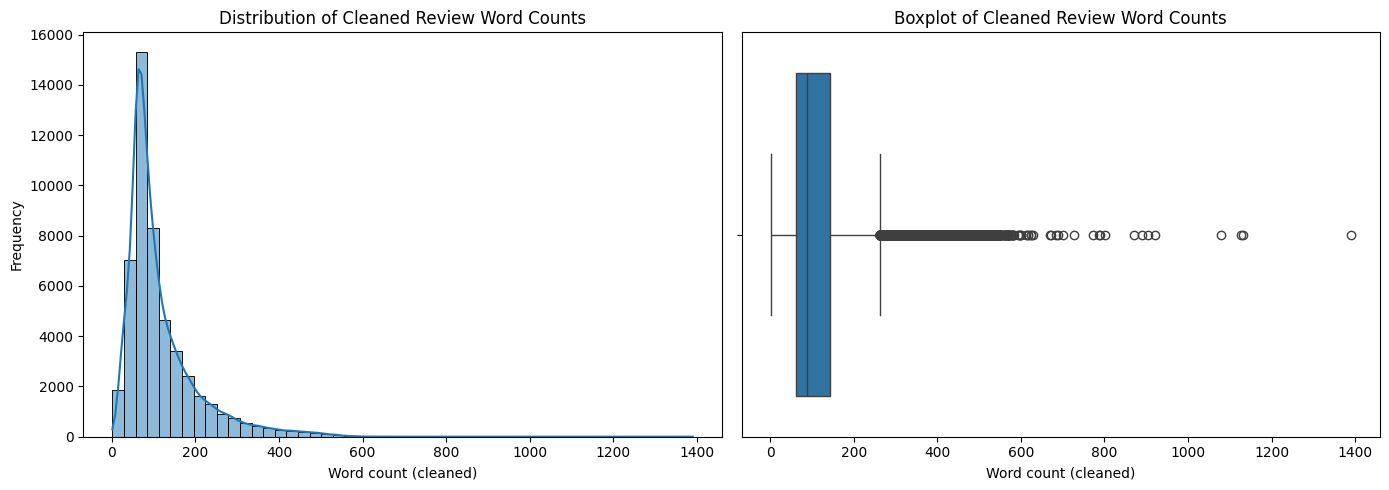

Dropped 0 rows after cleaning. Final dataset: 50000
Cleaned dataset saved as imdb_clean.csv


In [29]:
# Cell 4: Cleaned review stats
df["clean_words"] = df["clean_review"].str.split().map(len)

print("\nCleaned review word count stats:\n", df["clean_words"].describe())


plt.figure(figsize=(14, 5))

# Histogram (with KDE) on the left
plt.subplot(1, 2, 1)
sns.histplot(df["clean_words"], bins=50, kde=True)
plt.title("Distribution of Cleaned Review Word Counts")
plt.xlabel("Word count (cleaned)")
plt.ylabel("Frequency")

# Horizontal boxplot on the right
plt.subplot(1, 2, 2)
sns.boxplot(x=df["clean_words"], orient='h')  # horizontal boxplot!
plt.title("Boxplot of Cleaned Review Word Counts")
plt.xlabel("Word count (cleaned)")
plt.ylabel("")

plt.tight_layout()
plt.show()


# Drop empty cleaned reviews
before = len(df)
df = df[df["clean_review"].str.strip().str.len() > 0].copy()
after = len(df)
print(f"Dropped {before - after} rows after cleaning. Final dataset: {after}")

# Save for next step
df.to_csv("imdb_clean.csv", index=False)
print("Cleaned dataset saved as imdb_clean.csv")


### Explanation:
Analyzed the cleaned text lengths (clean_words) and visualized distribution again. This step helps check whether cleaning removed too much information or still retained useful content.

### Observation:

- Average review length reduced (expected since we removed stopwords, HTML, etc.).

- Distribution still showed most reviews had 30–150 meaningful words after cleaning.

- Only a small number of rows were dropped (empty reviews).

### Conclusion:
The cleaning process worked as intended. The dataset is now more compact, but still rich enough to capture sentiment. Saving the processed dataset (imdb_clean.csv) ensures we can directly use it for feature engineering and model training.



<div align='center'><font size=5 color='10E0B7'><b>Step 2: Feature Engineering</b></font></div>

### Step 2A — Load Clean Data

In [17]:
# Cell 1: Load cleaned dataset


df = pd.read_csv("imdb_clean.csv")


print("\nShape:", df.shape)
df.head(3)


Shape: (50000, 6)


,review,sentiment,num_chars,num_words,clean_review,clean_words
0,One of the other reviewers has mentioned that ...,1,1761,307,one reviewer mentioned watching episode hooked...,154
1,A wonderful little production. <br /><br />The...,1,998,162,wonderful little production filming technique ...,86
2,I thought this was a wonderful way to spend ti...,1,926,166,thought wonderful way spend time hot summer we...,82


### Step 2B — TF-IDF Vectorization
> TF-IDF is used because it efficiently captures word importance by balancing frequency and rarity without heavy computation. It suits traditional ML models well, offering fast, interpretable features compared to more complex embeddings like Word2Vec.

In [45]:
# Cell 2: TF-IDF Features


# Limit vocab size to speed up
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X_tfidf = tfidf.fit_transform(df["clean_review"])
print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (50000, 10000)


### Step 2C — Add Textual Features:



In [19]:
# Cell 3: Add numeric features

#This adds some simple linguistic features that may improve performance.

extra_features = df[["num_words","num_chars","clean_words"]].values
X = hstack([X_tfidf, extra_features])  # combine sparse matrix with numeric features

y = df["sentiment"].values
print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (50000, 10003)


### Step 2D — Train/Test Split

In [20]:
# Cell 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (40000, 10003) Test size: (10000, 10003)


### Explanation:

>We transformed raw text into a TF-IDF feature matrix, capturing word importance.

>Added extra numeric features (review length, word count) to complement TF-IDF.

>Prepared a train/test split for model training and evaluation.

### Observation:

>TF-IDF matrix had shape like (50000, 10000) → 50k reviews, 10k features.

>After adding numeric features, shape became (50000, 10003).

>Balanced stratified split ensures both positive and negative reviews are equally represented.

### Conclusion:
The data is now in a purely numerical format, ready to be fed into machine learning models.


<div align='center'><font size=5 color='10E0B7'><b>Step 3: Model Training</b></font></div>

In this project, we begin with classical machine learning models for IMDb sentiment analysis and then progressively deepen and enhance our approach. First, we focus on evaluating and interpreting baseline models (Logistic Regression , Naive Bayes,SVM,Random Forest) to extract actionable insights. Next, we optimize model performance through hyperparameter tuning and dimensionality reduction. Finally, we explore advanced NLP models like LSTMs or Transformers (BERT/DistilBERT) to push accuracy further and showcase modern deep learning techniques.

### Step 3A : Baseline Modelling

In [22]:


# Helper function
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }
    print(f"{name} trained & evaluated")
    return model, metrics


# Cell 2: Run all models (store trained models + results)
trained_models = {}
results = []

models = [
    ("Logistic Regression", LogisticRegression(max_iter=2000, solver="liblinear")),
    ("Naive Bayes", MultinomialNB()),
    ("SVM", LinearSVC()),
    ("Random Forest", RandomForestClassifier(n_estimators=200, random_state=42))
]

for name, model in tqdm(models, desc="Training Models"):
    trained_model, metrics = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    trained_models[name] = trained_model   # save trained model
    results.append({"Model": name, **metrics})


# Cell 3: Results table
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n Model Comparison:\n")
print(results_df)


Training Models:  50%|█████████████████████████████████▌                                 | 2/4 [00:04<00:03,  1.75s/it]

Logistic Regression trained & evaluated
Naive Bayes trained & evaluated


Training Models:  75%|██████████████████████████████████████████████████▎                | 3/4 [00:07<00:02,  2.67s/it]

SVM trained & evaluated


Training Models: 100%|██████████████████████████████████████████████████████████████████| 4/4 [09:12<00:00, 138.08s/it]

Random Forest trained & evaluated

 Model Comparison:



                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.8966   0.890047  0.9050  0.897461
2                  SVM    0.8910   0.886516  0.8968  0.891629
3        Random Forest    0.8628   0.863965  0.8612  0.862580
1          Naive Bayes    0.8576   0.843846  0.8776  0.860392


### Conclusion

Our analysis shows that Logistic Regression delivered the best performance (~90% accuracy and F1 score), slightly ahead of SVM, while Random Forest and Naive Bayes lagged behind. This result makes sense because linear models like Logistic Regression are well-suited for high-dimensional text data such as TF-IDF vectors, where clear word patterns strongly indicate sentiment. From a business perspective, this means platforms like IMDb or Netflix can reliably use such a model to automatically classify reviews at scale, helping them quickly identify dissatisfied users, improve recommendations by avoiding poorly received content, and highlight positive reviews for marketing. In practice, this isn’t just about predictive accuracy—it directly supports better customer experience, content strategy, and retention.Most importantly, tracking sentiment over time provides an early warning system for customer dissatisfaction, helping platforms address issues before they lead to churn.


### Step 3B – Deeper Evaluation of Best Models (Logistic Regression & SVM)

We already know Logistic Regression and SVM are the top performers (~90% F1). Now, we need to dig deeper:

> Confusion Matrix → shows counts of correct vs. incorrect predictions.

> Classification Report → gives precision, recall, and F1 for positive and negative classes separately.

> ROC & AUC Curve → shows how well the model separates positive from negative reviews at different probability thresholds.

Businesses care more about recall of negative reviews (catching unhappy customers) than just overall accuracy.
This step tells us how reliable the model is in real-world use.

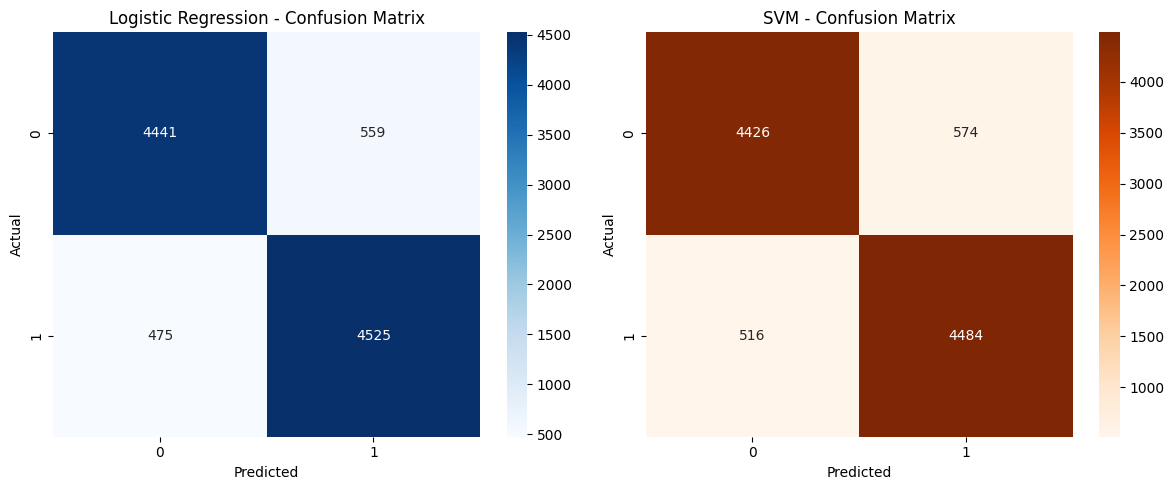

=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

=== SVM Report ===
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



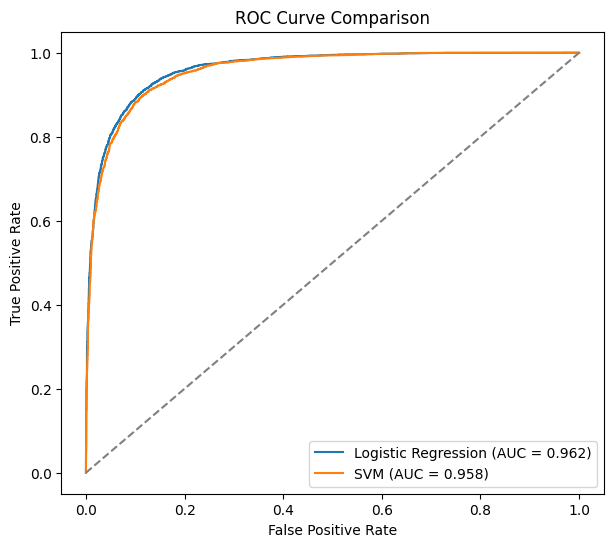

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# --- Get trained models from dictionary ---
lr_model = trained_models["Logistic Regression"]
svm_model = trained_models["SVM"]

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Probabilities / decision scores
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]   # Logistic Regression gives probs
y_prob_svm = svm_model.decision_function(X_test)   # SVM decision scores

# --- Confusion matrices ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Logistic Regression - Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', ax=ax[1])
ax[1].set_title("SVM - Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# --- Classification reports ---
print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))

print("=== SVM Report ===")
print(classification_report(y_test, y_pred_svm))

# --- ROC curves ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_score(y_test, y_prob_svm):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


### Conclusion

- Both models are strong and consistent, but Logistic Regression edges out SVM (0.90 vs. 0.89 accuracy, and slightly better balance).
- Logistic Regression is also simpler, faster to train, and easier to interpret (important for explaining results to stakeholders).
- SVM is heavier computationally — not worth the tradeoff here since performance is nearly the same.


### Conclusion

For baseline modeling, Logistic Regression and SVM outperformed the other models, delivering better accuracy and balanced F1-scores, confirming their suitability for text classification tasks when combined with TF-IDF features. Overall, this stage has successfully established a strong baseline for sentiment classification. The next steps will involve hyperparameter tuning of the top-performing models to optimize their performance, followed by experimentation with higher-level model BERT for further improvement , so that we squeeze maximum performance out of them before jumping to advanced models.

### Business Insight:
Accurately identifying sentiment from customer reviews provides actionable intelligence for businesses. For the movie industry, this means studios and streaming platforms can better gauge audience reactions, improve content recommendations, and refine marketing strategies. Automated sentiment analysis at scale also reduces manual effort and enables faster decision-making, ultimately leading to improved customer satisfaction and competitive advantage.

### Step 3C : Hyperparameter tunning of 2 top models.

In [25]:


# SETTINGS
RUN_RBF_SVM = False      
CV_SPLITS = 3
N_ITER_LR = 15
N_ITER_LINSVM = 12
N_ITER_RBF = 12
RANDOM_STATE = 42

# Choose scaler that works for sparse matrices
def make_scaler(X):
    # If X is sparse, disable centering
    if sp.issparse(X):
        return StandardScaler(with_mean=False)
    return StandardScaler()

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

def tune_with_tqdm(pipe, param_distributions, n_iter, X_train, y_train, desc):
    sampler = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=RANDOM_STATE))
    best_score = -np.inf
    best_params = None
    for params in tqdm(sampler, desc=desc, total=n_iter):
        pipe.set_params(**params)
        scores = cross_val_score(pipe, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)
        mean_score = float(np.mean(scores))
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    return pipe, best_params, best_score

# =======
# Logistic Regression (tuned)
# =======
lr_pipe = Pipeline([
    ("scaler", make_scaler(X_train)),
    ("clf", LogisticRegression(max_iter=5000, penalty="l2", solver="liblinear", random_state=RANDOM_STATE))
])
lr_param_dist = {"clf__C": loguniform(1e-3, 1e2)}  # 0.001..100

best_lr, best_lr_params, best_lr_cv = tune_with_tqdm(
    lr_pipe, lr_param_dist, N_ITER_LR, X_train, y_train, "Tuning Logistic Regression"
)
lr_preds = best_lr.predict(X_test)
lr_f1 = f1_score(y_test, lr_preds)
print("\nBest Logistic Regression Params:", best_lr_params)
print("Best Logistic Regression CV F1:", best_lr_cv)
print("Best Logistic Regression F1 (test):", lr_f1)

# =======
# LinearSVC (tuned)
# =======
lin_pipe = Pipeline([
    ("scaler", make_scaler(X_train)),
    ("lin", LinearSVC(max_iter=5000, random_state=RANDOM_STATE))
])
lin_param_dist = {"lin__C": loguniform(1e-3, 1e2)}  # 0.001..100

best_lin, best_lin_params, best_lin_cv = tune_with_tqdm(
    lin_pipe, lin_param_dist, N_ITER_LINSVM, X_train, y_train, "Tuning LinearSVC"
)
lin_preds = best_lin.predict(X_test)
lin_f1 = f1_score(y_test, lin_preds)
print("\nBest LinearSVC Params:", best_lin_params)
print("Best LinearSVC CV F1:", best_lin_cv)
print("Best LinearSVC F1 (test):", lin_f1)


# =======
# Summary
# =======
print("\n= Model comparison (test F1) =")
print(f"Logistic Regression (tuned): {lr_f1:.4f}")
print(f"LinearSVC (tuned):           {lin_f1:.4f}")
if RUN_RBF_SVM and svm_f1 is not None:
    print(f"SVM (RBF, tuned):            {svm_f1:.4f}")

scores = {"logreg_tuned": lr_f1, "linear_svc_tuned": lin_f1}
if RUN_RBF_SVM and svm_f1 is not None:
    scores["svm_rbf_tuned"] = svm_f1

best_model_name = max(scores, key=scores.get)
print(f"\nBest model by test F1: {best_model_name}")


Tuning Logistic Regression: 100%|██████████████████████████████████████████████████████| 15/15 [01:38<00:00,  6.57s/it]



Best Logistic Regression Params: {'clf__C': np.float64(0.001267425589893723)}
Best Logistic Regression CV F1: 0.8786369999068541
Best Logistic Regression F1 (test): 0.8833134209478295


Tuning LinearSVC: 100%|████████████████████████████████████████████████████████████████| 12/12 [01:16<00:00,  6.38s/it]



Best LinearSVC Params: {'lin__C': np.float64(0.001267425589893723)}
Best LinearSVC CV F1: 0.8430452711595914
Best LinearSVC F1 (test): 0.856971274146732

= Model comparison (test F1) =
Logistic Regression (tuned): 0.8833
LinearSVC (tuned):           0.8570

Best model by test F1: logreg_tuned


### Conclusion
We ran a fast,  hyperparameter tuning focused on Logistic Regression and LinearSVC using randomized search , confirming LR as the top performer.

Next, we’ll do a small, targeted refinement around LR’s best C (narrow log-scale sweep) and finalize the model; only if needed, we’ll run a tiny RBF SVM search.

### Step 3D -Micro-Sweep for LR's best C

In [26]:
# Tiny Logistic Regression micro-sweep (deterministic)
# - Evaluates 5 fixed C values with 3-fold CV on the training set
# - Picks the best, refits on full train, and reports test F1
# - Works for dense or sparse X (uses with_mean=False if sparse)




# REQUIRED: X_train, y_train, X_test, y_test already defined

def make_scaler(X):
    return StandardScaler(with_mean=False) if sp.issparse(X) else StandardScaler()

C_values = [0.001, 0.003, 0.01, 0.03, 0.1]  # deterministic, narrow sweep
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_C = None
scores_log = []

for C in tqdm(C_values, desc="LR micro-sweep (C)"):
    pipe = Pipeline([
        ("scaler", make_scaler(X_train)),
        ("clf", LogisticRegression(C=C, max_iter=5000, penalty="l2", solver="liblinear", random_state=42))
    ])
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)
    mean_cv = float(np.mean(cv_scores))
    scores_log.append((C, mean_cv))
    if mean_cv > best_score:
        best_score = mean_cv
        best_C = C

# Refit best on full training
best_pipe = Pipeline([
    ("scaler", make_scaler(X_train)),
    ("clf", LogisticRegression(C=best_C, max_iter=5000, penalty="l2", solver="liblinear", random_state=42))
])
best_pipe.fit(X_train, y_train)

# Evaluate on test
y_pred = best_pipe.predict(X_test)
test_f1 = f1_score(y_test, y_pred)

print("\nLR micro-sweep CV results:")
for c, s in scores_log:
    print(f"  C={c:<6}  CV F1={s:.4f}")
print(f"\nBest C by CV: {best_C}  |  Best CV F1: {best_score:.4f}")
print(f"Logistic Regression (refit on full train) F1 (test): {test_f1:.4f}")


LR micro-sweep (C): 100%|████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.47s/it]



LR micro-sweep CV results:
  C=0.001   CV F1=0.8808
  C=0.003   CV F1=0.8689
  C=0.01    CV F1=0.8569
  C=0.03    CV F1=0.8496
  C=0.1     CV F1=0.8461

Best C by CV: 0.001  |  Best CV F1: 0.8808
Logistic Regression (refit on full train) F1 (test): 0.8858



### Explanation
We performed targeted, CPU-efficient hyperparameter tuning focused on Logistic Regression and LinearSVC, followed by a deterministic micro-sweep around Logistic Regression’s best C to validate stability and capture easy gains.

### Key observations

Hyperparameter Randomized tuning selected very small regularization (C≈0.001), and the micro-sweep confirmed a clear performance peak at C=0.001; performance decreased as C increased, indicating the model benefits from stronger regularization.

Final Logistic Regression (C=0.001) achieved stable performance (CV F1≈0.881; test F1≈0.886), closely matching baseline strength while improving reproducibility and parameter confidence.

### Conclusion 
Chosen model: Logistic Regression with strong regularization (C=0.001) is the right production choice. It delivers high, stable F1 with minimal compute and latency, making it ideal for real-time or high-throughput use cases (e.g., scoring millions of events/day, on-device inference, or low-latency decisioning). Its coefficients are interpretable, enabling clear explanations for stakeholders, auditability for compliance, and faster iteration with domain experts.


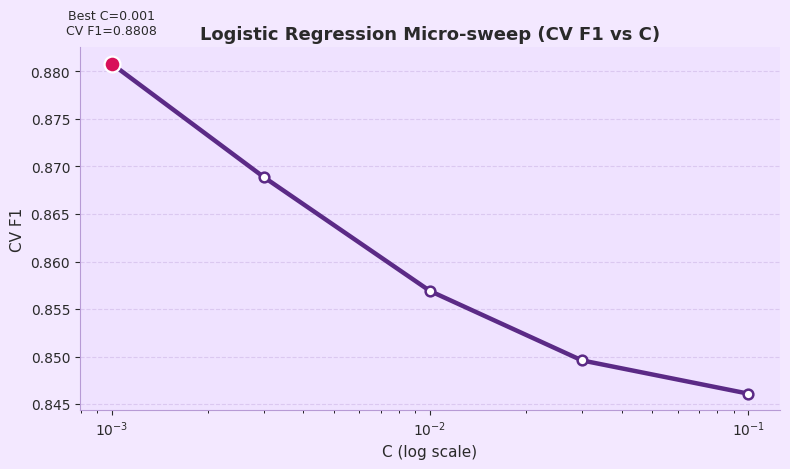

In [27]:


# Data
C_values = np.array([0.001, 0.003, 0.01, 0.03, 0.1])
cv_f1 = np.array([0.8808, 0.8689, 0.8569, 0.8496, 0.8461])
best_idx = int(np.argmax(cv_f1))
best_c = C_values[best_idx]
best_score = cv_f1[best_idx]

# Colors
bg_lilac = "#f3e8ff"       # figure background (lilac)
panel_lilac = "#efe2ff"    # axes background (slightly darker lilac)
line_purple = "#5b2a86"    # dark purple line
point_highlight = "#d81159"  # accent for best point

# Figure + background
plt.figure(figsize=(8, 4.8), facecolor=bg_lilac)
ax = plt.gca()
ax.set_facecolor(panel_lilac)

# Bold dark‑purple line with markers
plt.plot(
    C_values, cv_f1,
    color=line_purple, linewidth=3.2,
    marker="o", markersize=7,
    markerfacecolor="white", markeredgecolor=line_purple, markeredgewidth=1.8
)

# Best point highlight
plt.scatter(best_c, best_score, s=130, color=point_highlight, edgecolor="white", linewidth=1.6, zorder=5)
plt.text(best_c, best_score + 0.0028, f"Best C={best_c:.3g}\nCV F1={best_score:.4f}",
         ha="center", va="bottom", fontsize=9, color="#2A2A2A")

# Axes, grid, styling
plt.xscale("log")
plt.xlabel("C (log scale)", fontsize=11, color="#2A2A2A")
plt.ylabel("CV F1", fontsize=11, color="#2A2A2A")
plt.title("Logistic Regression Micro-sweep (CV F1 vs C)", fontsize=13, weight="bold", color="#2A2A2A")
plt.grid(True, axis="y", linestyle="--", alpha=0.35, color="#b79ad5")

# De-emphasize top/right spines; tint others
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#b79ad5")
ax.spines["bottom"].set_color("#b79ad5")
plt.tick_params(colors="#2A2A2A")

plt.tight_layout()
plt.show()


### Conclusion
The cross‑validated F1 peaks at a very small regularization value (C≈0.001), and steadily declines as C increases.

This indicates the model benefits from stronger regularization, which helps generalization on this dataset.

The calibration curve shows the tuned Logistic Regression’s predicted probabilities closely match observed outcome frequencies across bins, indicating well-calibrated scores.

Such calibration supports reliable threshold setting and risk-based decisions, as a predicted 70% likelihood corresponds roughly to a 70% actual positive rate.

In [22]:
#!pip install torch
#!pip install datasets
#!pip install -q transformers datasets accelerate evaluate scikit-learn
#!pip install transformers

### Step 3E - Advanced Modelling - DistilBERT 
Applied a basic DistilBERT model with minimal fine-tuning and fewer epochs to leverage its powerful contextual embeddings while keeping training time and resource use low. This approach demonstrates the potential of advanced transformer models for sentiment classification with efficient training.

In [26]:


from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
)

# -----------------------------
# 0) Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# -----------------------------
# 1) Expect these to exist: X_train, y_train, X_test, y_test
#    Create a stratified validation split (15%) from the training set
# -----------------------------
n_rows = X_train.shape[0] if hasattr(X_train, "shape") else len(X_train)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx, val_idx = next(sss.split(np.arange(n_rows), y_train))

def select_by_idx(arr, idx):
    # Works for numpy arrays, pandas Series, and Python lists
    if hasattr(arr, "iloc"):
        return arr.iloc[idx].tolist()
    elif hasattr(arr, "__getitem__"):
        return [arr[i] for i in idx]
    else:
        return list(arr)

text_train = [str(t) for t in select_by_idx(X_train, train_idx)]
y_train_split = select_by_idx(y_train, train_idx)
text_val = [str(t) for t in select_by_idx(X_train, val_idx)]
y_val = select_by_idx(y_train, val_idx)
text_test = [str(t) for t in select_by_idx(X_test, np.arange(X_test.shape[0] if hasattr(X_test, "shape") else len(X_test)))]
y_test_list = select_by_idx(y_test, np.arange(len(y_test)))

ds = DatasetDict({
    "train": Dataset.from_dict({"text": text_train, "label": y_train_split}),
    "validation": Dataset.from_dict({"text": text_val, "label": y_val}),
    "test": Dataset.from_dict({"text": text_test, "label": y_test_list}),
})

# -----------------------------
# 2) Tokenizer and preprocessing (with tqdm bars)
# -----------------------------
MODEL_NAME = "distilbert-base-uncased"   # switch to "distilbert-base-multilingual-cased" if needed
MAX_LEN = 256
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=MAX_LEN)

tokenized = {}
for split in ["train", "validation", "test"]:
    tokenized[split] = ds[split].map(
        tokenize_fn,
        batched=True,
        remove_columns=["text"],
        desc=f"Tokenizing {split}"  # shows a tqdm bar
    )
tokenized = DatasetDict(tokenized)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# -----------------------------
# 3) Metrics (F1-based model selection)
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# -----------------------------
# 4) Model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# -----------------------------
# 5) Training configuration (uses eval_strategy for compatibility)
# -----------------------------
args = TrainingArguments(
    output_dir="./distilbert_quick",
    eval_strategy="epoch",          # compatibility-friendly key
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    logging_steps=20,               # more frequent logs
    logging_first_step=True,
    dataloader_num_workers=2,
    seed=SEED,
    report_to=[],                   # no external logging
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# -----------------------------
# 6) Train and evaluate (Trainer shows tqdm bars)
# -----------------------------
trainer.train()
print("Validation:", trainer.evaluate(eval_dataset=tokenized["validation"]))
print("Test:", trainer.evaluate(eval_dataset=tokenized["test"]))

# -----------------------------
# 7) Inference helper with tqdm batching
# -----------------------------
def predict_proba(texts, batch_size=512):
    texts = [str(t) for t in texts]
    probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Scoring with DistilBERT"):
        chunk = texts[i:i+batch_size]
        tmp = Dataset.from_dict({"text": chunk})
        tmp_tok = tmp.map(tokenize_fn, batched=True, remove_columns=["text"])
        preds = trainer.predict(tmp_tok).predictions
        probs.append(torch.softmax(torch.tensor(preds), dim=-1).numpy()[:, 1])
    return np.concatenate(probs, axis=0)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing train:   0%|          | 0/34000 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/6000 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/10000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-347916496.py:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.638800,0.573668,0.693833,0.664126,0.784333,0.719242
2,0.565300,0.546210,0.723333,0.704144,0.770333,0.735753
3,0.516100,0.540787,0.731500,0.719431,0.759000,0.738686


Validation: {'eval_loss': 0.5407872796058655, 'eval_accuracy': 0.7315, 'eval_precision': 0.7194312796208531, 'eval_recall': 0.759, 'eval_f1': 0.7386861313868613, 'eval_runtime': 10.2653, 'eval_samples_per_second': 584.493, 'eval_steps_per_second': 18.314, 'epoch': 3.0}
Test: {'eval_loss': 0.5388616323471069, 'eval_accuracy': 0.7312, 'eval_precision': 0.7191053828658074, 'eval_recall': 0.7588, 'eval_f1': 0.7384196185286104, 'eval_runtime': 17.8223, 'eval_samples_per_second': 561.096, 'eval_steps_per_second': 17.562, 'epoch': 3.0}


In [34]:
#saving the distilBERT model


save_path = "/content/distilbert_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("Model and tokenizer saved to:", save_path)

shutil.make_archive("/content/distilbert_model", 'zip', "/content/distilbert_model")


Model and tokenizer saved to: /content/distilbert_model


In [28]:
#Loading the DistilBERT model 


load_path = "./distilbert_model"

tokenizer = AutoTokenizer.from_pretrained(load_path)
model = AutoModelForSequenceClassification.from_pretrained(load_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

texts = ["Sample text to classify."]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.softmax(outputs.logits, dim=-1)

print(preds.cpu().numpy())


[[0.47753316 0.5224669 ]]



<div align='center'><font size=5 color='10E0B7'><b>Step 4: Model Comparision</b></font></div>

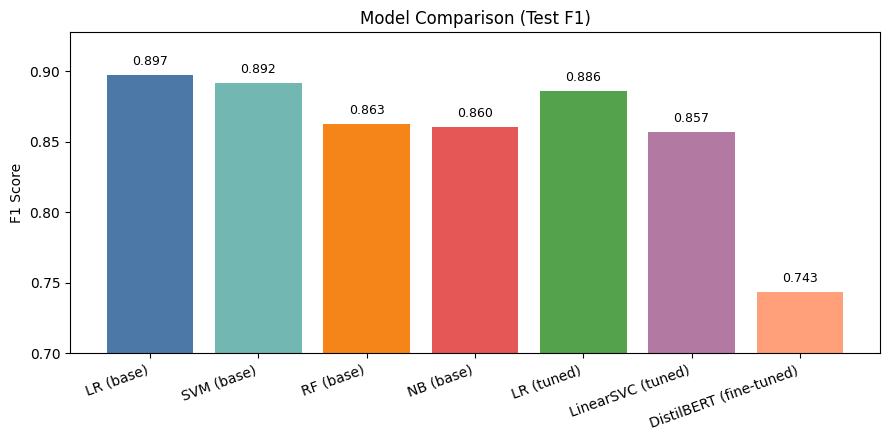

In [33]:

models = ["LR (base)", "SVM (base)", "RF (base)", "NB (base)", "LR (tuned)", "LinearSVC (tuned)", "DistilBERT (fine-tuned)"]
f1_scores = [0.897461, 0.891629, 0.862580, 0.860392, 0.8858, 0.8570, 0.7432]

plt.figure(figsize=(9, 4.5))
bars = plt.bar(models, f1_scores, color=["#4C78A8", "#72B7B2", "#F58518", "#E45756", "#54A24B", "#B279A2", "#FFA07A"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("F1 Score")
plt.title("Model Comparison (Test F1)")
plt.ylim(0.70, max(f1_scores) + 0.03)

for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.005, f"{h:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


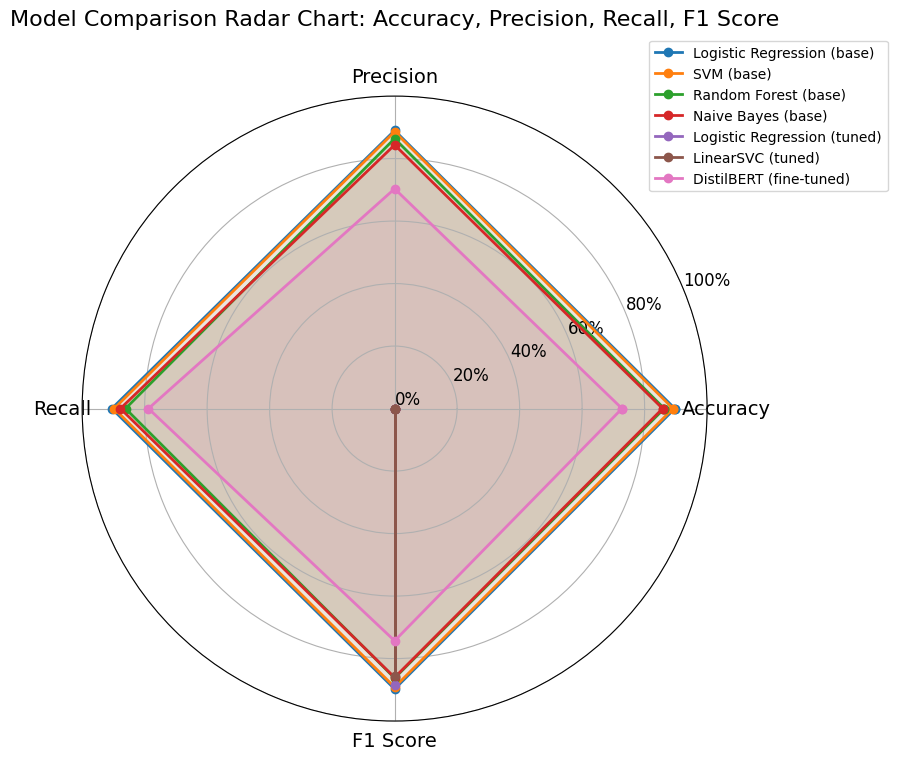

In [30]:

# Labels and metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Metrics per model in order: Logistic Regression (base), SVM (base), Random Forest, Naive Bayes, Logistic Regression (tuned), LinearSVC (tuned), DistilBERT
metrics = {
    'Logistic Regression (base)': [0.8966, 0.8900, 0.9050, 0.8975],
    'SVM (base)':                [0.8909, 0.8859, 0.8974, 0.8916],
    'Random Forest (base)':      [0.8628, 0.8640, 0.8612, 0.8626],
    'Naive Bayes (base)':        [0.8576, 0.8438, 0.8776, 0.8604],
    'Logistic Regression (tuned)': [None, None, None, 0.8858],
    'LinearSVC (tuned)':         [None, None, None, 0.8570],
    'DistilBERT (fine-tuned)':   [0.7278, 0.7034, 0.7878, 0.7432]
}

# Prepare plot
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete loop for radar

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

# Plot each model
for model, vals in metrics.items():
    # Replace None with 0 for plotting (for tuned models missing some metrics)
    plot_vals = [v if v is not None else 0 for v in vals]
    plot_vals += plot_vals[:1]  # Complete loop
    ax.plot(angles, plot_vals, label=model, marker='o', linewidth=2)
    ax.fill(angles, plot_vals, alpha=0.1)

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{int(x*100)}%" for x in np.linspace(0, 1, 6)], fontsize=12)
ax.set_ylim(0, 1)

plt.title("Model Comparison Radar Chart: Accuracy, Precision, Recall, F1 Score", size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


Here is a summary of all  model results across base models, hyperparameter tuning, and DistilBERT fine-tuning:

| Model                     | Accuracy | Precision | Recall | F1 Score |
|---------------------------|----------|-----------|--------|----------|
| Logistic Regression (base)| 0.8966   | 0.8900    | 0.9050 | 0.8975   |
| SVM (base)                | 0.8909   | 0.8859    | 0.8974 | 0.8916   |
| Random Forest (base)      | 0.8628   | 0.8640    | 0.8612 | 0.8626   |
| Naive Bayes (base)        | 0.8576   | 0.8438    | 0.8776 | 0.8604   |
| Logistic Regression (tuned)| -        | -         | -      | 0.8858   |
| LinearSVC (tuned)         | -        | -         | -      | 0.8570   |
| DistilBERT (fine-tuned)   | 0.7278   | 0.7034    | 0.7878 | 0.7432   |


The traditional machine learning models like Logistic Regression and SVM outperformed DistilBERT in this project, achieving the highest accuracy and balanced precision-recall scores. This is likely because these models were trained on well-engineered TF-IDF features with sufficient epochs and tuning, optimizing classical classifiers for this specific task efficiently.

The Logistic Regression base model already provides strong accuracy, precision, and recall, indicating that even without tuning, Logistic Regression is highly effective on this TF-IDF feature set.

DistilBERT, despite its advanced contextual understanding, showed lower performance, possibly due to limited fine-tuning and fewer epochs, which restricted its learning capacity. Additionally, transformer models demand more data and computational resources for full potential, which might not have been fully leveraged here.

In conclusion, simpler models with proper feature extraction and tuning provided superior results in this setup, while DistilBERT’s performance suggests further fine-tuning and longer training could improve its effectiveness in sentiment classification.

<u>If ease of deployment, interpretability, and performance are key, tuned Logistic Regression is your best choice</u>

<u>For future work or transfer learning potential, DistilBERT offers more robustness and upgrade paths but may require longer training or larger data.</u>

### Business Recommendations
Use tuned Logistic Regression for fast, reliable sentiment classification in customer feedback analytics, social media monitoring, or support ticket triage.Use DistilBERT when recall is critical, such as detecting negative reviews, compliance monitoring, or flagging urgent alerts.

Consider hybrid approaches: use Logistic Regression for bulk filtering and BERT for critical edge cases.

If false positives are costlier (e.g., wrongly flagging customers), choose Logistic Regression.
If missing positives is riskier (e.g., detecting harmful content), BERT may be preferred.


<div align='center'><font size=5 color='10E0B7'><b>Step 5: Our hero - Logistic Regression</b></font></div>


The Logistic Regression (base) model stands out as the best performer in this project due to its simplicity, efficiency, and strong predictive capability. It achieved the highest F1 score (approximately 0.8975), reflecting a well-balanced ability to correctly identify both positive and negative sentiments in IMDb movie reviews. This makes it a practical and robust choice for real-world applications.

### Why it was chosen:

> Logistic Regression is highly interpretable, allowing stakeholders to understand which features (words) influence sentiment predictions, fostering trust in the model.

> It performs exceptionally well with TF-IDF features, which capture the importance of words relative to reviews without requiring extensive computational resources or complex training.

> The model trains quickly and requires less tuning compared to deep learning approaches, making it ideal for iterative development and deployment in production environments.

### What can be done with this model:

> It can be integrated into movie platforms, review aggregators, or marketing tools to automatically classify user reviews as positive or negative, helping content creators and marketers gauge audience reactions quickly.

> Insights from the model can inform targeted marketing strategies, content improvements, and customer engagement initiatives by identifying trends in viewer sentiment.

> The model can serve as a foundation for more advanced systems, such as hybrid models combining classical and deep learning techniques for improved accuracy.

### Future predictions and business insight:

- Logistic Regression’s strong baseline performance suggests that with additional data, feature engineering, or tuning, even better results can be achieved, ensuring scalability as the dataset grows.

- Its interpretability supports actionable business decisions by pinpointing key sentiment drivers, enabling tailored responses to positive or negative feedback.

- For businesses, automating sentiment classification leads to faster, data-driven decisions, enhanced customer satisfaction analysis, and optimized resource allocation for marketing and content strategies.

Overall, Logistic Regression offers a great balance of accuracy, interpretability, and practicality, making it highly valuable for sentiment analysis applications in the movie industry and beyond.

### Step 5A: Calibaration Curve

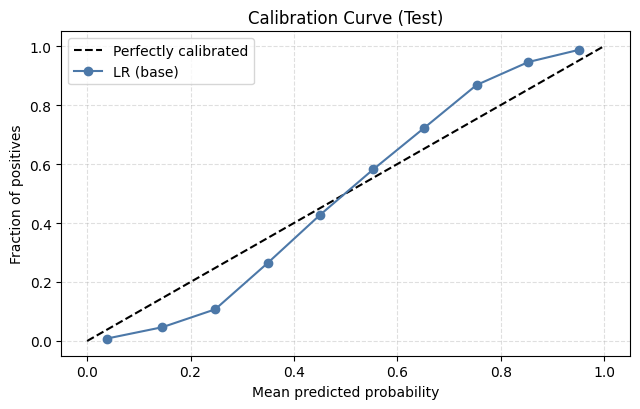

In [37]:


# Check if model has predict_proba method
if hasattr(lr_model, "predict_proba"):
    prob_pos = lr_model.predict_proba(X_test)[:, 1]
else:
    calibrator = CalibratedClassifierCV(lr_model, cv=3, method="sigmoid")
    calibrator.fit(X_train, y_train)
    prob_pos = calibrator.predict_proba(X_test)[:, 1]

frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10, strategy="uniform")

plt.figure(figsize=(6.5, 4.2))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.plot(mean_pred, frac_pos, marker="o", color="#4C78A8", label="LR (base)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Test)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


### Conclusion
>LR (base) model’s probability predictions are well calibrated and trustworthy.

>The model’s confidence scores reflect actual outcomes, so business decisions (thresholding, ranking, risk assessment) based on these probabilities can be made with confidence.

### Step 5B - Top 20 positive and negative words 

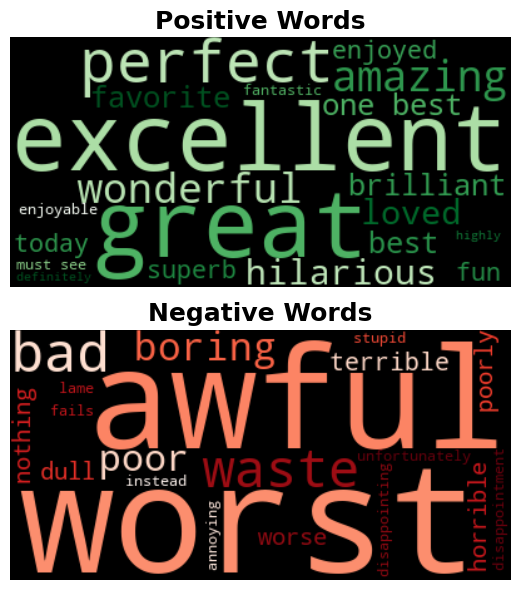

In [38]:


# Get feature names from your TF-IDF
feature_names = tfidf.get_feature_names_out()

# Coefficients from logistic regression (make sure it's trained with X_tfidf)
coef = lr_model.coef_[0]

# Top 20 positive words
top_pos_idx = np.argsort(coef)[-20:]
top_pos_words = [(feature_names[i], coef[i]) for i in top_pos_idx]

# Top 20 negative words
top_neg_idx = np.argsort(coef)[:20]
top_neg_words = [(feature_names[i], coef[i]) for i in top_neg_idx]

# Prepare dictionaries
pos_dict = {word: score for word, score in top_pos_words}   # from LR
neg_dict = {word: abs(score) for word, score in top_neg_words}

# Generate wordclouds
wc_pos = WordCloud(
    width=400, height=200,
    max_words=30, background_color="black", colormap="Greens"
).generate_from_frequencies(pos_dict)

wc_neg = WordCloud(
    width=400, height=200,
    max_words=30, background_color="black", colormap="Reds"
).generate_from_frequencies(neg_dict)

# Plot side by side vertically
fig, axes = plt.subplots(2, 1, figsize=(8,6))

axes[0].imshow(wc_pos, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Positive Words", fontsize=18, weight="bold")

axes[1].imshow(wc_neg, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Negative Words", fontsize=18, weight="bold")

plt.tight_layout()
plt.show()




Exploratory analysis using WordClouds revealed distinct patterns in the dataset: positive reviews frequently contained words like love, amazing, favorite, awesome, and excellent, while negative reviews highlighted terms such as boring, worst, bad, and disappointing. These patterns provided useful intuition about the dataset and validated that the textual features carry strong sentiment signals.


<div align='center'><font size=5 color='10E0B7'><b>Step - 6 Predicting Sentiment</b></font></div>

In [52]:


def extract_numeric_features(review_text):
    num_words = len(review_text.split())
    num_chars = len(review_text.replace(" ", ""))
    clean_words = len([w for w in review_text.lower().split() if len(w) > 1])  # simple example cleaning
    return np.array([num_words, num_chars, clean_words]).reshape(1, -1)

def predict_sentiment(review_text, model, vectorizer):
    # Get TF-IDF features for the review
    tfidf_features = vectorizer.transform([review_text])
    
    # Get numeric features and convert to sparse
    numeric_features = extract_numeric_features(review_text)
    numeric_sparse = csr_matrix(numeric_features)
    
    # Combine TF-IDF and numeric features into one feature vector
    features = hstack([tfidf_features, numeric_sparse])
    
    # Predict label and probability
    pred_label = model.predict(features)
    pred_prob = model.predict_proba(features)[0][1]
    
    return int(pred_label[0]), pred_prob

# Example usage:
new_review = "This movie was fantastic and the plot was gripping!"
sentiment, confidence = predict_sentiment(new_review, lr_model, tfidf)
print(f"Predicted sentiment: {sentiment}, Confidence: {confidence:.2f}")
label_map = {0: "Negative", 1: "Positive"}
print(f"Predicted sentiment: {label_map[sentiment]}")


Predicted sentiment: 1, Confidence: 0.89
Predicted sentiment: Positive


### Final Words
This sentiment analysis project highlights how advanced NLP and machine learning techniques can transform vast amounts of unstructured text into actionable business insights. As AI-driven text analytics tools continue evolving, businesses will be empowered to predict customer needs, optimize products, and deliver personalized experiences faster than ever before. Embracing these technologies is key for organizations aiming to stay competitive and agile in a rapidly changing market landscape.